# **Time Series Model**

Time Series Models are a method of forecasting wherein we assume that the target variable varies with respect to Time. Here, our target variable is the "Close" value of a stock at the end of the trading period for the day. The problem statement falls under univariate time series forecasting since we are only concerned about the "Close" value and forecasting said value.

## Exploratory Data Analysis

By default, pandas loads all string columns with "object" datatype.However, in this case, it helps to parse the "date" column into DatetimeIndex format as we are focusing on building a model to forecast "Close" as a function of Time. We use the pd.to_datetime function to convert the date column to datetime format. We also set the date column as the index of the dataframe to help in easier plotting and manipulation of data

In [2]:
import pandas as pd

In [3]:
from google.colab import files
uploaded=files.upload()

Saving Life Expectancy Data.csv to Life Expectancy Data.csv
Saving number-of-deaths-by-risk-factor.csv to number-of-deaths-by-risk-factor.csv


<h3> Loading the Data and Merging data <h3>

In [14]:
dfLifeExpectancy = pd.read_csv("Life Expectancy Data.csv",parse_dates=True)
dfDeaths = pd.read_csv("number-of-deaths-by-risk-factor.csv")

<h4> Preprocessing Life Expectancy Dataset <h4>


In [15]:
dfLifeExpectancy.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


<h5> Setting proper format </h5>


In [16]:
dfLifeExpectancy['Year'] = pd.to_datetime(dfLifeExpectancy.Year, format='%Y') #Converting year to datetime format

In [69]:
dfLifeExpectancy.dtypes

Country                                    object
Year                               datetime64[ns]
Status                                     object
Life expectancy                           float64
Adult Mortality                           float64
infant deaths                               int64
Alcohol                                   float64
percentage expenditure                    float64
Hepatitis B                               float64
Measles                                     int64
 BMI                                      float64
under-five deaths                           int64
Polio                                     float64
Total expenditure                         float64
Diphtheria                                float64
 HIV/AIDS                                 float64
GDP                                       float64
Population                                float64
 thinness  1-19 years                     float64
 thinness 5-9 years                       float64


<h5> Checking for Null values </h5>

In [37]:
dfDummy = dfLifeExpectancy.dropna()

In [38]:
dfDummy.shape

(1649, 22)

In [39]:
len(dfDummy['Country'].unique())

133

In [63]:
missing = (dfDummy.isna().sum()).sort_values(ascending=False)

In [64]:
temp = pd.DataFrame(dfDummy.groupby('Country').count()['Year'])
temp = temp[temp['Year'] >= 15]
temp['Country'] = temp.index
listOfCountries = list(temp['Country'])

In [66]:
dfLifeExpectancy = dfLifeExpectancy[dfLifeExpectancy['Country'].isin(listOfCountries)]
dfLifeExpectancy.shape

(960, 22)

### Decomposing the components of Time Series

We plot the year stamp along with the life expectancy value for China and Germany. There is a clear trend line depicting increasing growth of life expectancy for China. 

In [109]:
dfTimeSeriesChina = dfLifeExpectancy[dfLifeExpectancy['Country'] == 'China'][['Year','Life expectancy ']]

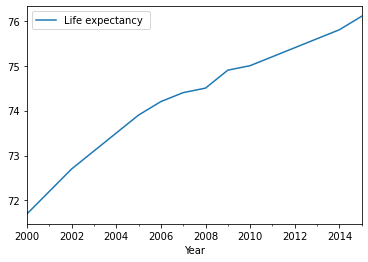

In [110]:
dfTimeSeriesChina.plot(x='Year', y='Life expectancy ')

We plot the same graph for Germany. However, in this case we seem a varying trend line. Moroever both graphs, lack depiction of seasonality and cyclic nature. This could be due to the fact that the dataset only covers life expectancy from 2000 to 2015 which may not be enough to depict the other components

In [111]:
dfTimeSeriesGermany = dfLifeExpectancy[dfLifeExpectancy['Country'] == 'Germany'][['Year','Life expectancy ']]

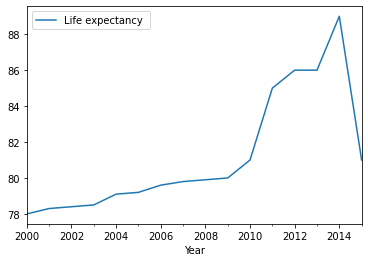

In [112]:
dfTimeSeriesGermany.plot(x='Year', y='Life expectancy ')

#### Considering Seasonality
Seasonality is an important component of Time Series Forecasting. There are cases where removal of Seasonality helps accuracy while in other cases modelling seasonality better can improve accuracy. As previously identified, we notice that the graphs only have a trend component but lack seasonality 

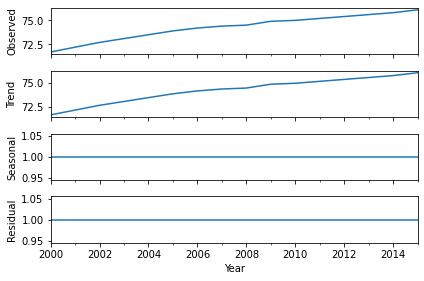

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = dfTimeSeriesChina.copy()
analysis = analysis.set_index('Year')
analysis.head()
analysis.sort_index(inplace=True)
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative",freq=1)

seasonal = decompose_result_mult.seasonal

decompose_result_mult.plot();

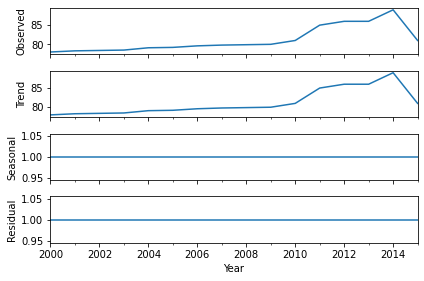

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis1 = dfTimeSeriesGermany.copy()
analysis1 = analysis1.set_index('Year')
analysis1.head()
analysis1.sort_index(inplace=True)
decompose_result_mult = seasonal_decompose(analysis1, model="multiplicative",freq=1)

seasonal = decompose_result_mult.seasonal

decompose_result_mult.plot();

### Tests for Stationary Data <br>
1. Visualisation tests: As we see in the above-decomposed graphs, there exists a clear trend line and some seasonality in the data. This is proof of the fact that the data is not stationary 
2. Summary statistics: Usually shown via histogram charts and various stats, such as Mean, Median and so on. With the histogram, we try to show that the data follows a normal curve. If it does, the data is stationary. With summary statistics, we try to show that there isn't a major difference between the summary statistics of buckets of data.
3. Statistical tests: We use tests like the Augmented Dicky-Fuller test to show that the data is stationary. 

We have finished the first test as a part of our approach to decomposing data into its components. The second and third tests will be demonstrated in the cells below

#### Using summary statistics to identify stationary data

We plot a histogram of the Close prices. Usually, for stationary data, the above histogram either has a normal distribution or an approximately normal distribution. However, in our case, we notice that the graph has a normal distribution for China but not for Germany

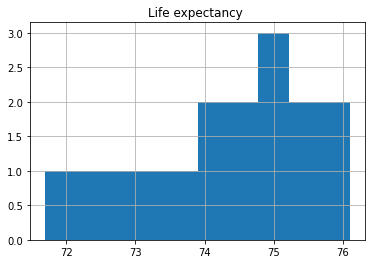

In [120]:
analysis.hist()
pyplot.show()

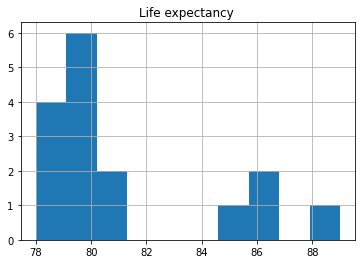

In [121]:
analysis1.hist()
pyplot.show()

We split the data into two buckets to test if the data is stationary. By nature, if the data is stationary, the mean and variance of the two buckets is the same or comparable. However, as see below, the mean is comparable for the two buckets and the variance differs from 0.6 

In [122]:
X = analysis.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=73.212500, mean2=75.312500
variance1=0.816094, variance2=0.236094


Based on the above graphs, we conclude that the time series data for a country is not stationary. This is also validated by the clear presence of a trend line. For the sake of this project, we limit ourselves to the data of one country i.e China

#### Augmented Dicky-Fuller test to identify stationary data

Augmented Dicky-Fuller Test: Post decomposition, we perform the Dicky-Fuller Test to verify if the given data is stationary. If the data is not stationary, we will have to perform transformations to make it stationary before proceeding with time series modelling. Although the clear presence of seasonality and trend supports our claim that the stock market data is not stationary. The ADF test helps in solidifying this claim. The ADF test is a hypothesis test wherein the null hypothesis is that the data has a unit root i.e the data is non-stationary.

In [127]:
from statsmodels.tsa.stattools import adfuller

CloseValues = analysis['Life expectancy '].values

result = adfuller(CloseValues)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.614703
p-value: 0.089996
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


Here, we see that the ADF Statistic value is far greater than the critical value displayed. Due to this, we fail to reject the Null Hypothesis. If we fail to reject the Null Hypothesis, it implies that the data is non-Stationary. 

### Auto-Correlation tests <br>
Autocorrelation is a crucial feature in time series forecasting. When we talk about autocorrelation with a lag 'k', we want to find the correlation of the Close Price on day T with the Close Price on day T-K. It is important for the data to be correlated with each other since it guides the model in forecasting via the AutoRegressive (AR) parameter

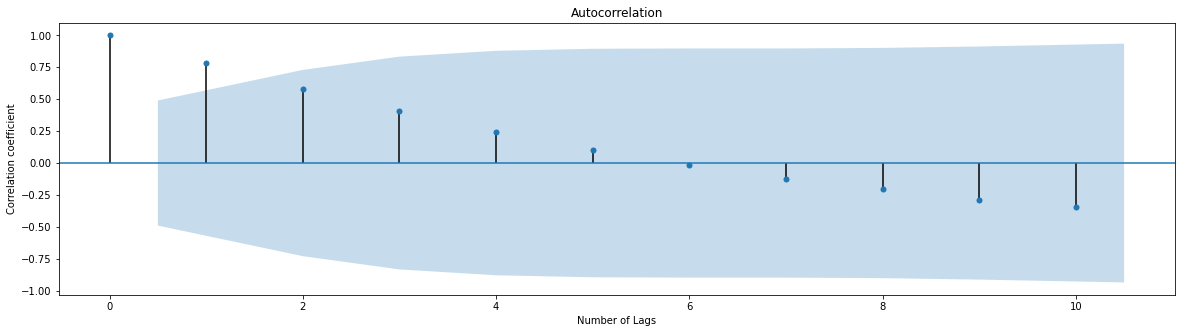

In [129]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
fig1,ax1 = plt.subplots(figsize=(20, 5))
ax1.set_xlabel("Number of Lags")
ax1.set_ylabel("Correlation coefficient")
plot_acf(analysis, lags=10, ax=ax1)
plt.show()

The highlighted portion represents the lags where correlation is no longer significant. Here, we notice that beyond a lag value of 2, the Life expectancy Value on the 3rd year and prior do not have an impact on the the value of the current year. 

The Partial Correlation Function plots help us find out if there is any hidden information in the residual that can be used for modelling. We also use the PACF plots to identify the value of q or the Moving Average order 

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


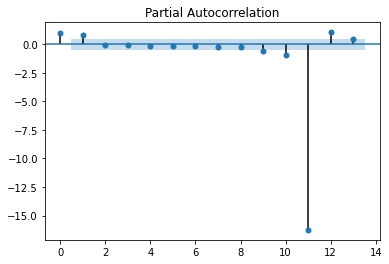

In [131]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(analysis['Life expectancy ']);

### Conclusions of EDA <br>
1. The data has clear trend line as shown via graphs 
2. The data has seasonality which is demonstrated via the graph decomposition 
3. The data is non-stationary as demonstrated via graphs, summary statistics and the ADF test 
4. There is a significant positive correlation for the first 2 lags 